## 导入必要的包

这里我们使用`MNIST`数据集，采用`Paddle`框架自带的`MNIST`模块进行读取

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import paddle
import paddle.nn as nn
from paddle.vision.datasets import MNIST,Cifar10
from paddle.io import Dataset
import warnings
warnings.filterwarnings("ignore")

## 数据可视化

In [2]:
mnist = MNIST(mode='train')

In [3]:
def plot_num_images(num):
    if num < 1:
        print('INFO:The number of input pictures must be greater than zero!')
    else:
        choose_list = []
        for i in range(num):
            choose_n = np.random.randint(len(mnist))
            choose_list.append(choose_n)
        fig = plt.gcf()
        fig.set_size_inches(15, 17)
        for i in range(num):
            ax_img = plt.subplot(math.ceil(num / 2), 5, i + 1)
            plt_img = mnist[choose_list[i]][0]
            ax_img.imshow(plt_img, cmap='binary')
            ax_img.set_title(str(mnist[choose_list[i]][1].item()),
                             fontsize=20)
        plt.show()


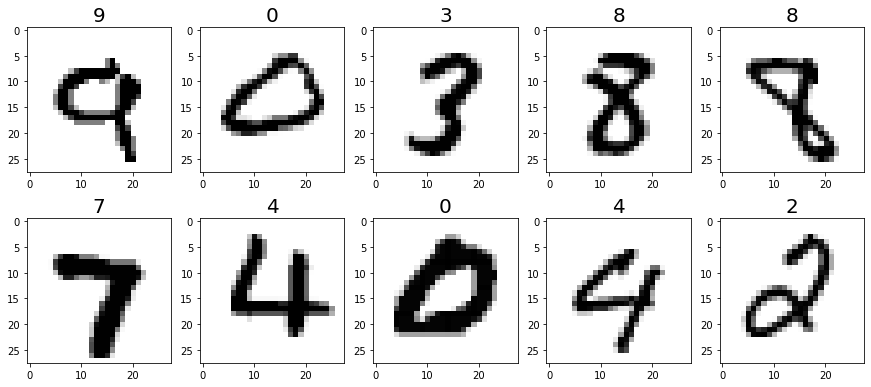

In [4]:
plot_num_images(10)

## 数据装载

In [5]:
class MnistDataset(Dataset):
    def __init__(self, mode='train'):
        super(MnistDataset, self).__init__()
        self.data = [[np.array(mnist[i][0]).astype('float32') / 255.0, mnist[i][1].astype('int64')] for i in range(len(mnist))]
    def __getitem__(self, index):
        data = self.data[index][0]
        label = self.data[index][1]

        return data, label

    def __len__(self):
        return len(self.data)

In [6]:
train_loader = paddle.io.DataLoader(MnistDataset(mode='train'), batch_size=256, shuffle=True)

## 定义AutoEncoder

In [7]:
class AutoEncoder(nn.Layer):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3))

        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid())
    
    def forward(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)

        return encoded, decoded

查看网络结构

In [8]:
network = AutoEncoder()
model = paddle.Model(network)
model.summary((784))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Linear-1           [[784]]               [128]             100,480    
    Tanh-1            [[128]]               [128]                0       
   Linear-2           [[128]]                [64]              8,256     
    Tanh-2             [[64]]                [64]                0       
   Linear-3            [[64]]                [12]               780      
    Tanh-3             [[12]]                [12]                0       
   Linear-4            [[12]]                [3]                39       
   Linear-5            [[3]]                 [12]               48       
    Tanh-4             [[12]]                [12]                0       
   Linear-6            [[12]]                [64]               832      
    Tanh-5             [[64]]                [64]                0       
   Linear-7            [[64]]       

{'total_params': 219891, 'trainable_params': 219891}

设置超参数

In [9]:
paddle.framework.seed(1)

EPOCH = 100
BATCH_SIZE = 256
LR = 0.0005
N_TEST_IMG = 10

定义优化器和损失函数

In [10]:
optimizer = paddle.optimizer.Adam(parameters=network.parameters(), learning_rate=LR)
loss_func = nn.MSELoss()

开始训练

In [11]:
view_data = np.array([np.array(mnist[i][0]) / 255.0 for i in range(N_TEST_IMG)]).reshape(-1, 28 * 28).astype('float32')

step_loss_list = []
decoded_img_list = []
epoch_loss_list = []
network.train()
for epoch in range(EPOCH):
    for x, _ in train_loader:
        train_x = x.reshape([-1, 28 * 28])
        encoded, decoded = network(train_x)
        loss = loss_func(decoded, train_x)
        loss.backward()
        optimizer.step()
        optimizer.clear_grad()
        step_loss_list.append(loss.numpy())
    if (epoch + 1) % 5 == 0:
        print('Epoch: %2d' % (epoch + 1), '| train loss: %.4f' % np.mean(step_loss_list))
    epoch_loss_list.append(np.mean(step_loss_list))
    _, decoded_data = network(paddle.to_tensor(view_data))
    decoded_img_list.append(decoded_data)


Epoch:  5 | train loss: 0.0642
Epoch: 10 | train loss: 0.0556
Epoch: 15 | train loss: 0.0503
Epoch: 20 | train loss: 0.0469
Epoch: 25 | train loss: 0.0445
Epoch: 30 | train loss: 0.0427
Epoch: 35 | train loss: 0.0414
Epoch: 40 | train loss: 0.0403
Epoch: 45 | train loss: 0.0395
Epoch: 50 | train loss: 0.0387
Epoch: 55 | train loss: 0.0381
Epoch: 60 | train loss: 0.0376
Epoch: 65 | train loss: 0.0371
Epoch: 70 | train loss: 0.0366
Epoch: 75 | train loss: 0.0363
Epoch: 80 | train loss: 0.0359
Epoch: 85 | train loss: 0.0356
Epoch: 90 | train loss: 0.0353
Epoch: 95 | train loss: 0.0351
Epoch: 100 | train loss: 0.0348


损失可视化

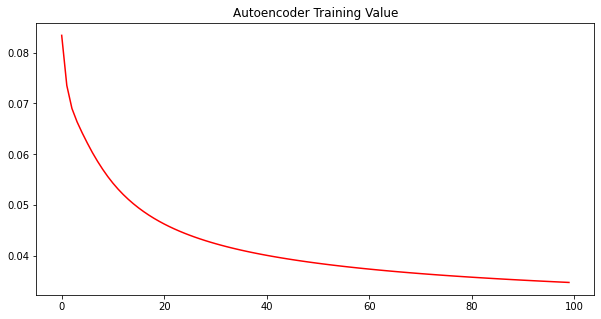

In [12]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epoch_loss_list, color=(1, 0, 0))
plt.title('Autoencoder Training Value')
plt.show()

## 动图生成

In [13]:
import imageio
import cv2

img_data = view_data
concat_img = []
black = np.zeros([28, 1])
anim_file = 'assets/autoencoder.gif'

img_raw = np.hstack((img_data[0].reshape(28, 28) * 255, black,
                     img_data[1].reshape(28, 28) * 255, black,
                     img_data[2].reshape(28, 28) * 255, black,
                     img_data[3].reshape(28, 28) * 255, black,
                     img_data[4].reshape(28, 28) * 255, black,
                     img_data[5].reshape(28, 28) * 255, black,
                     img_data[6].reshape(28, 28) * 255, black,
                     img_data[7].reshape(28, 28) * 255, black,
                     img_data[8].reshape(28, 28) * 255, black,
                     img_data[9].reshape(28, 28) * 255)).astype('uint8')
size = (int(img_raw.shape[1] * 2.4), int(img_raw.shape[0] * 2.4))
img_raw = cv2.resize(img_raw, size)

with imageio.get_writer(anim_file, mode='I') as writer:
    for i in range(len(decoded_img_list)):
        img_decode = np.hstack((decoded_img_list[i].cpu().detach().numpy()[0].reshape(28, 28) * 255, black,
                         decoded_img_list[i].cpu().detach().numpy()[1].reshape(28, 28) * 255, black,
                         decoded_img_list[i].cpu().detach().numpy()[2].reshape(28, 28) * 255, black,
                         decoded_img_list[i].cpu().detach().numpy()[3].reshape(28, 28) * 255, black,
                         decoded_img_list[i].cpu().detach().numpy()[4].reshape(28, 28) * 255, black,
                         decoded_img_list[i].cpu().detach().numpy()[5].reshape(28, 28) * 255, black,
                         decoded_img_list[i].cpu().detach().numpy()[6].reshape(28, 28) * 255, black,
                         decoded_img_list[i].cpu().detach().numpy()[7].reshape(28, 28) * 255, black,
                         decoded_img_list[i].cpu().detach().numpy()[8].reshape(28, 28) * 255, black,
                         decoded_img_list[i].cpu().detach().numpy()[9].reshape(28, 28) * 255)).astype('uint8')
        img_decode = cv2.resize(img_decode, size)
        img = np.vstack((img_raw, img_decode))
        writer.append_data(img)


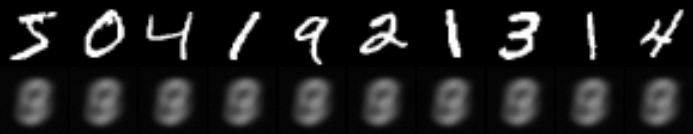

## 三维分布可视化

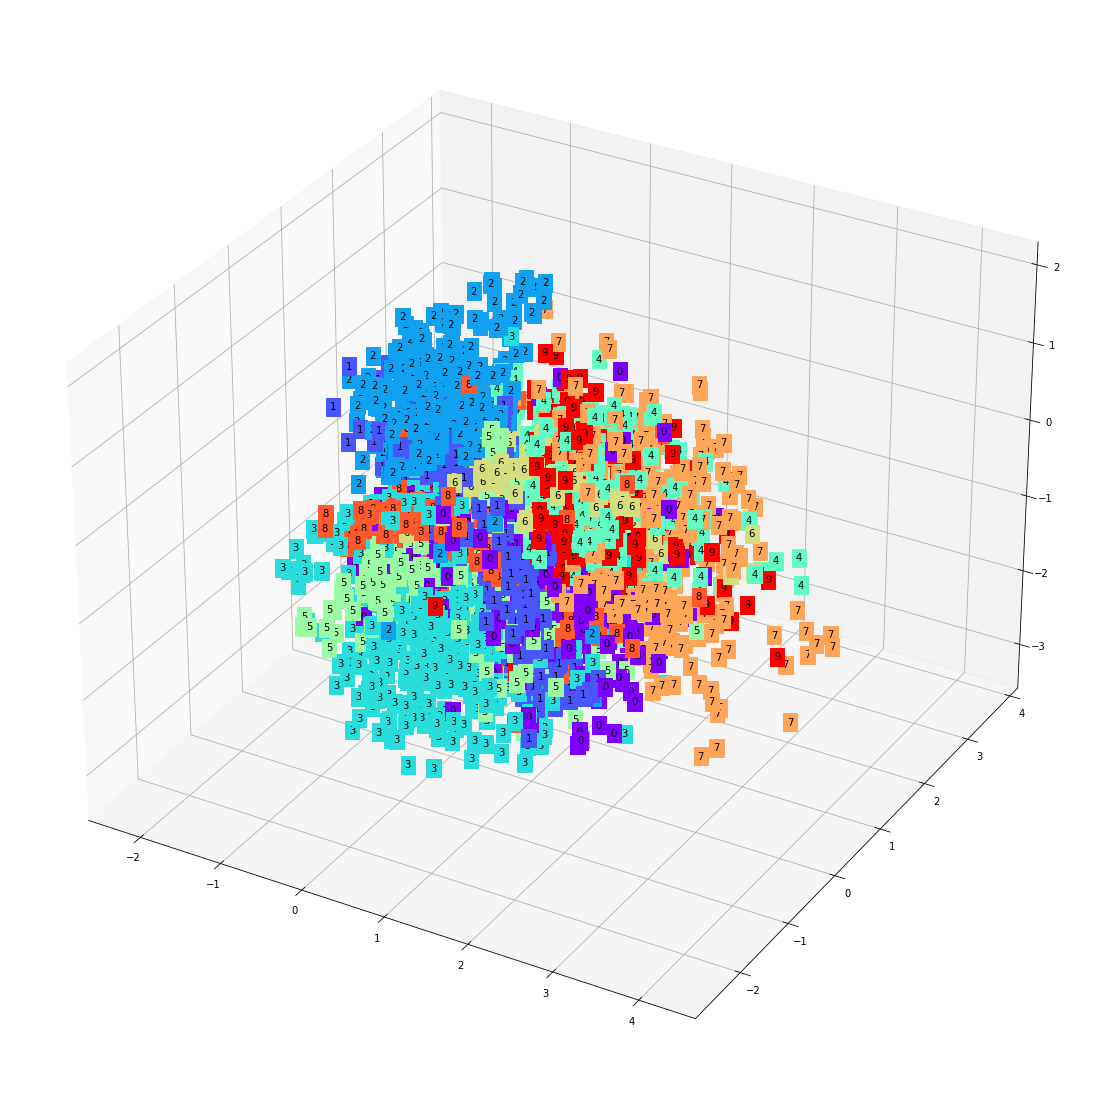

In [14]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

network.eval()
view_data = np.array([np.array(mnist[i][0]) / 255.0 for i in range(5000)]).reshape(-1, 28 * 28).astype('float32')
encoded_data, _ = network(paddle.to_tensor(view_data))
fig = plt.figure(2)
fig.set_size_inches(15, 15)
ax = Axes3D(fig)
X, Y, Z = encoded_data.numpy()[:, 0], encoded_data.numpy()[:, 1], encoded_data.numpy()[:, 2]
values = [np.array(mnist[i][1]).item() for i in range(5000)]
for x, y, z, s in zip(X, Y, Z, values):
    c = cm.rainbow(int(255 * s / 9))
    ax.text(x, y, z, s, backgroundcolor=c)
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()